# Processing and generate Data

In [2]:
#import libraries
# This ensures visualizations are plotted inside the notebook
%matplotlib inline
import io
import os              # This provides several system utilities
import pandas as pd    
import seaborn as sns 
import numpy as np
import rtree
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
from cenpy import products
import cenpy
import scipy.stats  as stats # low-level stats & probability
import statsmodels.formula.api as smf # high-level stats
import requests
import contextily as ctx
import rasterio as rio
import pysal as ps


C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


In [3]:
# download from https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-05.csv
taxi_data = pd.read_csv('yellow_tripdata_2019-05.csv')

In [5]:
taxi_data["pickuptime"] = pd.to_datetime(taxi_data["tpep_pickup_datetime"])
taxi_data["dropofftime"] = pd.to_datetime(taxi_data["tpep_dropoff_datetime"])
taxi_data["hour"] = taxi_data["pickuptime"].map(lambda x: x.hour)
taxi_data["weekday"] = taxi_data["pickuptime"].map(lambda x: x.weekday)
taxi_data["weekday_name"] = taxi_data["pickuptime"].map(lambda x: x.day_name)
taxi_lite = taxi_data[['PULocationID','DOLocationID','trip_distance','pickuptime','dropofftime','hour','weekday_name']]
week_mask = (taxi_lite['pickuptime'] >= '2019-5-6') & (taxi_lite['pickuptime'] < '2019-5-13')
#get sample data of one week
sampleweek_taxi_lite = taxi_lite.loc[week_mask]
#get hourly count
hour_si = pd.DataFrame({'count' : sampleweek_taxi_lite.groupby(['PULocationID','DOLocationID','hour'] ).size()}).reset_index()
hour_si = hour_si[hour_si['PULocationID']!=hour_si['DOLocationID']]
hour_si = hour_si[ (hour_si['PULocationID']<264) & (hour_si['DOLocationID']<264)]
# due to missing records of 264 and 265 in shp

#get distances
taxi_zone = gpd.read_file('taxi_zones/taxi_zones.shp')
centroids =  ps.lib.weights.get_points_array_from_shapefile("taxi_zones/taxi_zones.shp")
dist_mat = ps.lib.cg.distance_matrix(centroids)
dist_mat

for i, row in hour_si.iterrows():
    hour_si.at[i,'Dij'] = dist_mat[int(row['PULocationID']-1)][int(row['DOLocationID']-1)]
#generate final dataframe containing O,D,Dist,flow
df = pd.DataFrame()
for hr in range(24):
    hour1 = hour_si[hour_si['hour'] == hr]
    
    res_do = pd.DataFrame(hour1.groupby('DOLocationID')['count'].count())
    res_do['hour'] = hr * np.ones(res_do.shape)
    res_do = res_do.astype({'hour': 'int32'})
    res_do = res_do.rename(columns = {'count':'Dj'})
    
    res_pu = pd.DataFrame(hour1.groupby('PULocationID')['count'].count())
    res_pu['hour'] = hr * np.ones(res_pu.shape)
    res_pu = res_pu.astype({'hour': 'int32'})
    res_pu = res_pu.rename(columns = {'count':'Oi'})
    
    hour1_O = pd.merge(hour1, res_pu,how = 'left',on=['PULocationID', 'hour'])
    hour1_OD = pd.merge(hour1_O, res_do,how = 'left',on=['DOLocationID', 'hour'])
    hour1_OD = hour1_OD.rename(columns={'count':'flow'})
    #print(hour1_OD.head())
    df = df.append(hour1_OD)
df
# find (PU,DO) that has hour [0,...,23]
grouped = df.groupby(['PULocationID','DOLocationID'])

df2 = grouped.aggregate(lambda x: np.array(x))
df_full = df2[df2['hour'].apply(lambda x: x.size) ==24]
df_clear_full = df_full.reset_index()[['Oi','Dj','Dij','flow']]

Y = df_clear_full['flow'].to_numpy()
Y = np.stack(Y, axis=0)
Y[0].reshape(24,-1,1)

X_pd = df_clear_full[['Oi','Dj','Dij']]

X = np.array([], dtype=np.int64).reshape(0,3)
for i, row in X_pd.iterrows():
    X_row = np.array( [row['Oi'],row['Dj'],row['Dij']])
#     print(X_row.T)
#     print(X_row.T.shape)
    X = np.vstack([X, X_row.T]) if X.size else X_row.T
#     if i > 2:
#         break
X_re1 = X.reshape(-1,24,3)


In [6]:
X_d2 = X_re1[:1000,].reshape(-1,24*3)
X_d2.shape

(1000, 72)

In [7]:
X_d2[:,0:3].shape

(1000, 3)

In [8]:
X_head = X_d2[:,0:3]

In [9]:
Y = Y[:1000,].reshape(-1,24,1,1)
Y.shape

Y_d2 = Y.reshape(-1,24*1)
Y_d2.shape

Y_d2

Y_d2[:,-1].shape
Y_tail = Y_d2[:,-1]

Y_head = Y_d2[:,0].reshape(-1,1)
Y_head.shape

(1000, 1)

In [11]:
from sklearn.preprocessing import normalize
normed_Y = normalize(Y_head, axis=0, norm='l1')


In [12]:
np.save('simple_X',X_head)
np.save('simple_Y',Y_head)

# Using PyTorch to implement LSTM model

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
lstm = nn.LSTM(3, 1)  # Input dim is 3, output dim is 3
inputs = torch.from_numpy(X_d4).float()

print(inputs[0])

#BUG: double input variables not accepted by LSTM, got error message:
# RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2'


In [52]:
split_frac = 0.5 # 50% validation, 50% test
split_id = int(split_frac * len(X_d2))
val_X, test_X = X_d2[:split_id], X_d2[split_id:]
val_Y, test_Y = Y_tail[:split_id], Y_tail[split_id:]

In [53]:
from torch.utils.data import TensorDataset, DataLoader


In [54]:
train_data = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).float())
val_data = TensorDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_Y).float())

In [55]:
X_d2

array([[   60.        ,    68.        ,  2857.6722853 , ...,
           63.        ,    71.        ,  2857.6722853 ],
       [   33.        ,    59.        ,  9644.64563124, ...,
           24.        ,    55.        ,  9644.64563124],
       [   33.        ,    38.        ,  4955.55320952, ...,
           24.        ,    37.        ,  4955.55320952],
       ...,
       [   82.        ,    52.        , 15915.83056906, ...,
           91.        ,    56.        , 15915.83056906],
       [   82.        ,    60.        ,  8932.67314552, ...,
           91.        ,    58.        ,  8932.67314552],
       [   82.        ,    56.        , 11496.0026935 , ...,
           91.        ,    67.        , 11496.0026935 ]])

In [56]:
batch_size = 2

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [57]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [62]:
class TSINet(nn.Module):
    def __init__(self, input_size,batch_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(TSINet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x,hidden):
        x=x.t()
        x = x.reshape(x.size(0),self.batch_size, -1)
#         print('input shape')
#         print(x.shape)

        
        lstm_out, hidden = self.lstm(x, hidden)
#        print('lstm out and hidden0 shape')
#         print(lstm_out.shape)
#         print(hidden[0].shape)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [63]:
input_size = 1
output_size = 1
hidden_dim = 64
n_layers = 2

model = TSINet(input_size,batch_size, output_size, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [ ]:
epochs = 200
counter = 0
print_every = 100
clip = 5
valid_loss_min = np.Inf
seq_length = 72
model.train()
for i in range(epochs):
    h = model.init_hidden(seq_length)
    
    for inputs, labels in train_loader:
        counter += 1
#         print(inputs.t().shape)

        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(seq_length)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

In [ ]:
# initialize the hidden state.
hidden = (torch.randn(1, 1, 1),
          torch.randn(1, 1, 1))


hidden

In [ ]:
for i in inputs[0]:
    print(i)
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

    print(out)
    print(hidden)

In [42]:
lstm = nn.LSTM(3, 1)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(24)]  # make a sequence of length 5
print(inputs)
# initialize the hidden state.
hidden = (torch.randn(1, 1, 1),
          torch.randn(1, 1, 1))
for i in inputs:
    print(i)
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

[tensor([[1.5174, 1.6815, 0.6686]]), tensor([[-1.3771, -0.4192, -1.4726]]), tensor([[-0.4775,  0.5501, -1.1967]]), tensor([[ 0.0489, -1.8084,  2.0058]]), tensor([[0.9735, 0.5364, 0.7165]]), tensor([[ 1.2615, -0.0659,  2.3018]]), tensor([[-1.4944, -1.0577, -1.2188]]), tensor([[0.7033, 1.0838, 1.4373]]), tensor([[0.4898, 1.7899, 0.9227]]), tensor([[ 1.4088, -0.4567,  0.1100]]), tensor([[-0.2419,  0.2401,  1.4360]]), tensor([[-0.0668,  0.8720,  0.6791]]), tensor([[-0.4543, -0.2149, -1.8579]]), tensor([[-0.4278,  1.8769,  0.8630]]), tensor([[0.0771, 0.9061, 1.2043]]), tensor([[ 1.3060,  0.5141, -1.2784]]), tensor([[-1.3969, -1.2800, -0.2468]]), tensor([[-0.4159,  1.1004,  0.1369]]), tensor([[-1.4131,  0.6246, -2.1237]]), tensor([[-0.0387,  0.2975, -1.7019]]), tensor([[-0.1952, -1.8107, -1.9912]]), tensor([[-0.2434, -0.5782,  0.6942]]), tensor([[-1.0025, -0.0356, -1.3917]]), tensor([[-0.3523,  1.9390,  0.4224]])]
tensor([[1.5174, 1.6815, 0.6686]])
tensor([[-1.3771, -0.4192, -1.4726]])
tenso

In [182]:
# Example from https://www.jessicayung.com/lstms-for-time-series-in-pytorch/
# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(72, 64, batch_size=4, output_dim=1, num_layers=1)

In [183]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [184]:
num_epochs = 100
hist = np.zeros(num_epochs)

In [69]:
X_train = torch.from_numpy(X_d4).float()

In [70]:
model.zero_grad()
model.hidden = model.init_hidden()
y_pred = model(X_train)
y_pred

tensor([-0.0611], grad_fn=<ViewBackward>)

In [ ]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Clear stored gradient
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

# Manual simple NN

In [58]:
#sigmoid function
def sigmoid(X):
    return 1/(1+np.exp(-X))

def sigmoid_derivative(X):
    return sigmoid(X) * (1 - sigmoid(X))

def tanh(z):
    return np.tanh(z)

def tanh_grad(z):
     return 1 - np.tanh(z) ** 2

def ReLU(z):
    return np.clip(z, 0, np.inf)

def ReLU_grad(z):
    return (z > 0).astype(int)

def affine(X,slope=1,intercept=0):
     return slope * X + intercept
    
def affine_grad(X,slope=1,intercept=0):
    return slope * np.ones_like(X)

class NeuralNetwork:
    def __init__(self, input_dim, output_dim=1,lr=0.005):
        
        self.weights1   = np.random.rand(input_dim,4) 
        self.weights2   = np.random.rand(4,1)                 
        
        self.lr         = lr
    def print_w(self):
        print('print_w:')
        print('w:')
        print(self.weights1)
        print(self.weights2)
    def feedforward(self,X):
        self.layer1 = sigmoid(np.dot(X, self.weights1))
#         print('layer1')
#         print(self.layer1)
#         print(np.dot(self.layer1, self.weights2))
        self.output = sigmoid(np.dot(self.layer1, self.weights2))
        
#         print('forwardout')
#         print(self.output)
    def backprop(self,X, Y):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(Y - self.output) * sigmoid_derivative(np.dot(self.layer1, self.weights2))))
        d_weights1 = np.dot(X.T,  \
                            (np.dot(2*(Y - self.output) * sigmoid_derivative(np.dot(self.layer1, self.weights2)), self.weights2.T)\
                             * sigmoid_derivative(np.dot(X, self.weights1))))
#         print('d_w1')
#         print(d_weights1)
#         print('d_w2')
#         print(d_weights2)
        # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1*self.lr
        self.weights2 += d_weights2*self.lr
    def test(self,data):
        #print(data)
        out_layer1 = sigmoid(np.dot(data, self.weights1))
        return sigmoid(np.dot(out_layer1, self.weights2))
        
    def train(self,X,Y,num_train_iterations): 
        for iteration in range(num_train_iterations): 
            self.feedforward(X) 
            #self.print_w()
            self.backprop(X,Y)
            #self.print_w()
            if iteration % 100000 == 0:
                mse = np.mean((self.output - Y)**2)
                print("Epoch ", iteration, "MSE: ", mse)
                

In [4]:
X = np.load('simple_X.npy')
Y = np.load('simple_Y.npy')

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [51]:
X_train = np.load('trivial_add_in.npy')
y_train = np.load('trivial_add_out.npy')
X_test  = np.load('trivial_add_tin.npy')[:10,]
y_test  = np.load('trivial_add_tout.npy')[:10,]

In [34]:
y_train.reshape(-1).shape

(100,)

In [38]:
dataset = pd.DataFrame({'X1': X_train[:, 0], 'X2': X_train[:, 1],'X3': X_train[:,2], 'y':y_train.reshape(-1)})
model = smf.ols('y~X1+X2+X3', data=dataset).fit()

In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.208e+32
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:32:56   Log-Likelihood:                 3578.2
No. Observations:                 100   AIC:                            -7148.
Df Residuals:                      96   BIC:                            -7138.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.776e-17   2.12e-17      1.312      0.193   -1.42e-17    6.97e-17
X1             0.3333   2.38e-17    1.4e+16      0.000       0.333       0.333
X2             0.3333   2.55e-17   1.31e+16      0.000       0.333       0.333
X3             0.3333   2.47e-17   1.35e+16      0.000       0.333       0.333
==============================================================================
Omnibus:                        2.185   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.335   Jarque-Bera (JB):                1.771
Skew:                           0.321   Prob(JB):                        0.412
Kurtosis:                       3.114   Cond. No.                         5.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# # For trivial dataset
# X_train = np.load('trivial_in.npy')[:100,]
# y_train = np.load('trivial_out.npy')[:100,]
# X_test = np.array([[1, 0, 0]])
# y_test = np.array([[1]])

In [62]:
batch_size = 4
# X_test_slice = X_test[:10,]
# y_test_slice = y_test[:10,]
neural_network = NeuralNetwork(3,1,lr=1)

for index in range(0,X_train.shape[0],batch_size):
    batch_X=X_train[index:min(index+batch_size,X_train.shape[0]),:]
    batch_Y=y_train[index:min(index+batch_size,y_train.shape[0])]


    neural_network.train(batch_X,batch_Y,500000) 
    neural_network.print_w()

    # Test the neural network with a new situation. 
    print ("Testing MSE on new examples ->") 
    
    y_pred = neural_network.test(X_test)
    print(y_pred)
    print(y_test)
    mse = np.mean((y_test - y_pred)**2)
    print(mse)

Epoch  0 MSE:  0.09126839943463383
Epoch  100000 MSE:  9.678953528512493e-30
Epoch  200000 MSE:  4.314083075427408e-31
Epoch  300000 MSE:  4.314083075427408e-31
Epoch  400000 MSE:  4.314083075427408e-31
print_w:
w:
[[-0.3840239   0.86346254 -0.09180607  2.18339648]
 [-1.12348837  0.40654829  0.72032576  0.30371878]
 [-1.36394178  0.90924602  0.29380448 -0.70813657]]
[[-6.69712411]
 [ 0.49606867]
 [-0.57414312]
 [ 1.8580863 ]]
Testing MSE on new examples ->
[[0.71195239]
 [0.33748515]
 [0.32905681]
 [0.46220717]
 [0.3976536 ]
 [0.43155132]
 [0.46416862]
 [0.65344375]
 [0.52042258]
 [0.35861529]]
[[0.8147038 ]
 [0.35870648]
 [0.37194116]
 [0.47298015]
 [0.40965842]
 [0.41951059]
 [0.45831198]
 [0.67439782]
 [0.54407605]
 [0.35353644]]
0.001431107238843359
Epoch  0 MSE:  0.0010553879929466445
Epoch  100000 MSE:  2.894118807701927e-13
Epoch  200000 MSE:  1.6108386110134998e-21
Epoch  300000 MSE:  3.7197410945895073e-29
Epoch  400000 MSE:  1.2418396281408897e-30
print_w:
w:
[[-0.03065492  0

KeyboardInterrupt: 

In [ ]:
# PyTorch simple NN

In [72]:

from torch.autograd import Variable
import torch.nn.functional as F

In [63]:
def train(model, epoch, criterion, optimizer, data_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader):
        if cuda_gpu:
            data, target = data.cuda(), target.cuda()
            model.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 400 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * len(data), len(data_loader.dataset),
                100. * (batch_idx+1) / len(data_loader), loss.data[0]))

In [64]:
def test(model, epoch, criterion, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        if cuda_gpu:
            data, target = data.cuda(), target.cuda()
            model.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(data_loader) # loss function already averages over batch size
    acc = correct / len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset), 100. * acc))
    return (acc, test_loss)

In [96]:
from sklearn.datasets import make_regression
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set()

x_train, y_train, W_target = make_regression(n_samples=100, n_features=1, noise=1, coef = True)
x_train[:,0]

array([ 0.1200316 , -0.29743934, -0.04680083, -1.09951908,  0.93325838,
       -0.96146334, -0.48316631,  1.31597987,  0.97514011,  0.72879973,
        0.03357932, -0.24503645, -0.39372671,  0.65938907,  0.34883533,
       -0.64919665, -0.72613393, -0.01364653,  0.63252934,  0.0204372 ,
       -0.12778696, -0.31003516, -1.2401461 ,  1.15040962,  0.57146278,
        1.36472933, -0.9473326 , -0.38521173, -0.20773179,  0.95023917,
        1.02297765, -1.06688455, -0.53688861,  1.08205386, -0.83792327,
       -0.15144443, -2.37210933,  0.69739925,  0.02223237, -0.56304962,
        1.54098464, -0.88481618,  0.93107118,  0.33258876,  1.13566404,
        0.78928099, -0.99949509, -0.74632323,  0.76567017, -1.40157169,
       -1.8881677 , -0.49125796,  0.9378908 ,  1.1937171 , -2.1338117 ,
       -1.01792292, -0.18666733,  0.29230986, -1.09024831, -0.27043559,
       -0.58365002,  0.96089592, -1.09975038,  0.84939133,  0.5452521 ,
        0.91265126, -0.09294232,  0.5517376 ,  1.59760682,  1.23

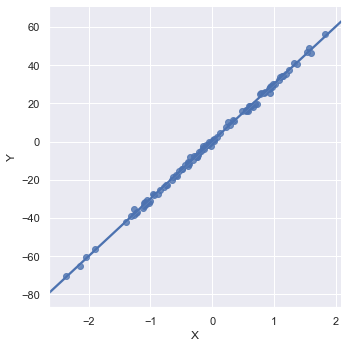

In [97]:
df = pd.DataFrame(data = {'X':x_train[:,0].ravel(), 'Y':y_train.ravel()})

sns.lmplot(x='X', y='Y', data=df, fit_reg=True)
plt.show()

x_torch = torch.FloatTensor(x_train)
y_torch = torch.FloatTensor(y_train)
y_torch = y_torch.view(y_torch.size()[0], 1)

In [98]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, output_size,hidden_size=4):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)  
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

model = SimpleNN(1, 1)

In [79]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)  
        
    def forward(self, x):
        return self.linear(x)

model = LinearRegression(1, 1)

In [103]:

print('internal parameters:')
for name,param in model.named_parameters():
    print(name + ": ", type(param), param.size())
    print('---------------------------------------------------------------------------------------')

internal parameters:
fc1.weight:  <class 'torch.nn.parameter.Parameter'> torch.Size([4, 1])
---------------------------------------------------------------------------------------
fc1.bias:  <class 'torch.nn.parameter.Parameter'> torch.Size([4])
---------------------------------------------------------------------------------------
fc2.weight:  <class 'torch.nn.parameter.Parameter'> torch.Size([1, 4])
---------------------------------------------------------------------------------------
fc2.bias:  <class 'torch.nn.parameter.Parameter'> torch.Size([1])
---------------------------------------------------------------------------------------


In [104]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  


for epoch in range(500):
    data, target = Variable(x_torch), Variable(y_torch)
    output = model(data)
        
    optimizer.zero_grad()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
        
predicted = model(Variable(x_torch)).data.numpy()

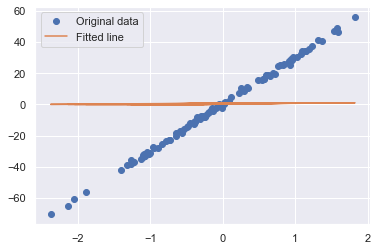

In [105]:

plt.plot(x_train, y_train, 'o', label='Original data')
plt.plot(x_train, predicted, label='Fitted line')
plt.legend()
plt.show()

In [106]:
t = model.fc1.weight
print (type(t))
print (t.size())
print (t)

<class 'torch.nn.parameter.Parameter'>
torch.Size([4, 1])
Parameter containing:
tensor([[ 4.7249],
        [ 2.5333],
        [ 2.0610],
        [-5.2015]], requires_grad=True)
